In [1]:
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from random import randint
import random
import torch.distributions as D
from torch.utils.data import DataLoader, TensorDataset
global  samplesJoint,tp_dataloader,tp_dataloader_testing,dp,decision,dp_H,decision_H
from pylab import *
from scipy.stats import beta
import math
n = 3
epochs = 1
supervisionEpochs = 1
lr = 0.0005
log_interval = 20
trainSize = 60000#100000
percentage_train_test= 0.25
penaltyLambda = 10
doublePeakHighMean = 0.9
doublePeakLowMean = 0.1
doublePeakStd = 0.1
uniformlow=0
uniformhigh=1.0
normalloc = 0.2
normalscale = 0.1

cauchyloc = 1/n
cauchyscalen = 0.004

exponentialhigh = 15 #Symbol("b", real=True)
exponentiallow  = 15 #Symbol("a", real=True)


beta_a = 0.1
beta_b  = 0.1
kumaraswamy_a = beta_a 
kumaraswamy_b = (1.0+(beta_a-1.0)*math.pow( (beta_a+beta_b-2.0)/(beta_a-1.0), beta_a) )/beta_a 
print(kumaraswamy_b)

independentnormalloc1=[(float(ii)+1)/(2*n+1) for ii in range(n,0,-1)]
independentnormalscale1=[0.05 for ii in range(n)]

independentnormalloc2=[(float(ii)+1)/(2*n+1) for ii in range(1,n+1,1)]
independentnormalscale2=[0.05 for ii in range(n)]
stage=["twopeak"]
order="twopeak"
# "twopeak","normal","uniform","independent1","independent2","cauchy","beta","U-exponential","arcsine"
order1name=["costsharing","random initializing","dp"]
#order1name=["random initializing1","random initializing2","random initializing3"]
# "costsharing","dp","heuristic","random initializing"

0.3540388371733616


In [2]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
d1 = D.normal.Normal(doublePeakLowMean, doublePeakStd)
d2 = D.normal.Normal(doublePeakHighMean, doublePeakStd)
distributionRatio1 = (d1.cdf(1) + d2.cdf(1) - d1.cdf(0) - d2.cdf(0)) / 2
distributionBase1 = d1.cdf(0) + d2.cdf(0)

d3 = D.normal.Normal(normalloc, normalscale)
distributionRatio3 = d3.cdf(1) - d3.cdf(0)
distributionBase3 = d3.cdf(0)

d4 = D.uniform.Uniform(uniformlow,uniformhigh)
distributionRatio4 = d4.cdf(1) - d4.cdf(0)
distributionBase4 = d4.cdf(0)

d5 = [D.normal.Normal(independentnormalloc1[ii], independentnormalscale1[ii]) for ii in range(n)]
d6 = [D.normal.Normal(independentnormalloc2[ii], independentnormalscale2[ii]) for ii in range(n)]

d7 = D.cauchy.Cauchy(cauchyloc,cauchyscalen)

d81 = D.exponential.Exponential(exponentiallow)
d82 = D.exponential.Exponential(exponentialhigh)

d9 = D.beta.Beta(beta_a,beta_b)
#sample_d9=d9.rsample(torch.Size([100000]))

#d9_sample=np.linspace(0.0001, 0.9999, 10000)
#d9_pdf=torch.exp(d9.log_prob(torch.tensor(d9_sample,dtype=torch.float32)))
#d9_delta=d9_sample[1]-d9_sample[0]
#d9_sum_pdf=torch.sum(d9_pdf*d9_delta)

d10 = D.beta.Beta(0.5,0.5)

def cdf(x,y, i=None):
    if(y=="twopeak"):
        return (d1.cdf(x) + d2.cdf(x) - distributionBase1) / 2 / distributionRatio1
    elif(y=="normal"):
        return (d3.cdf(x)-distributionBase3)/distributionRatio3;
    elif(y=="uniform"):
        return (d4.cdf(x)-distributionBase4)/distributionRatio4;
    elif(y=="independent1"):
        return d5[i].cdf(x);
    elif(y=="independent2"):
        return d6[i].cdf(x);
    elif(y=="cauchy"):
        return d7.cdf(x);
    elif(y=="beta"):
#         sum_cdf=0.0;
#         if(x<0.0001):
#             x=0.00011;
#         if(x>0.9999):
#             x=0.99989;
#         for i in range(len(d9_pdf)):
#             if(d9_sample[i]<x):
#                 sum_cdf+=d9_pdf[i]*d9_delta;
#             else:
#                 sum_cdf+=(d9_pdf[i]+d9_pdf[i-1])/ 2 *(x-d9_sample[i-1])
#                 break;
#         return sum_cdf/d9_sum_pdf
#         cdf_v=torch.sum((sample_d9<(x)), dtype=torch.float32)/100000
#         return cdf_v
#    F(x|a,b)=1–(1–x^a)^b
        if(x<0.0000001):
            x=0.0000001
        elif(x >0.9999999):
            x=0.9999999
        try:
            return 1.0-torch.pow(1.0-torch.pow(x,kumaraswamy_a),kumaraswamy_b);
        except:
            return 1.0-torch.pow(1.0-torch.pow(torch.tensor(x,dtype=torch.float32),kumaraswamy_a),kumaraswamy_b);
    elif(y=="arcsine"):
        #
        if(x<0.0000001):
            x=0.0000001
        elif(x >0.9999999):
            x=0.9999999
        try:
            res=2.0/math.pi * torch.asin(torch.sqrt(x))
            #print(x)
            return res# + 0.0001*1.0/(
            #math.pi * torch.sqrt(torch.tensor(x)*torch.tensor(1.0-x)))
        except:
            return 2.0/math.pi * torch.asin(torch.sqrt(torch.tensor(x,dtype=torch.float32)))# + 0.0001*1.0/(
            #math.pi * torch.sqrt(torch.tensor(x)*torch.tensor(1.0-x)))
    elif(y=="U-exponential"):
        return (d81.cdf(x) + (1.0 - d82.cdf(1.0-x)))  / 2 
    

In [4]:
dpPrecision = 100
# howManyPpl left, money left, yes already
dp = np.zeros([n + 1, dpPrecision + 1])
decision = np.zeros([n + 1, dpPrecision + 1], dtype=np.uint8)
# ppl = 0 left
for money in range(dpPrecision + 1):
    if money == 0:
        dp[0, 0] = 1
    else:
        offer = money / dpPrecision
        dp[0, money] = 0#cdf(offer)# + 1.0
for ppl in range(1, n + 1):
    for money in range(dpPrecision + 1):
        maxSoFar = -1_000_000
        for offerIndex in range(money + 1):
            offer = offerIndex / dpPrecision
            res = (1-cdf(offer,order)) * dp[
                 ppl - 1, money - offerIndex
                ]
            if maxSoFar < res:
                maxSoFar = res
                decision[ppl, money] = offerIndex
        dp[ppl, money] = maxSoFar
print(dp[n, dpPrecision])
print(n*(1-dp[n, dpPrecision]))

0.2585742771625519
2.2242771685123444


In [5]:

        
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.1)


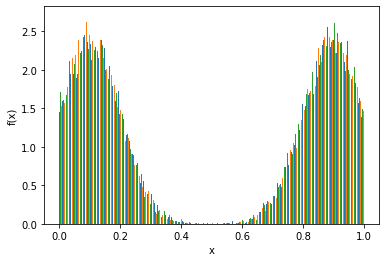

In [15]:
signals = np.random.randint(2, size=(trainSize, n))
# samples1 = np.random.uniform(low=0.1, high=0.2, size=(trainSize, n))
# samples2 = np.random.uniform(low=0.8, high=0.9, size=(trainSize, n))
samples1 = np.random.normal(
    loc=doublePeakLowMean, scale=doublePeakStd, size=(trainSize, n)
)
for i in range(trainSize):
    for j in range(n):
        while samples1[i, j] < 0 or samples1[i, j] > 1:
            samples1[i, j] = np.random.normal(
                loc=doublePeakLowMean, scale=doublePeakStd
            )
samples2 = np.random.normal(
    loc=doublePeakHighMean, scale=doublePeakStd, size=(trainSize, n)
)
for i in range(trainSize):
    for j in range(n):
        while samples2[i, j] < 0 or samples2[i, j] > 1:
            samples2[i, j] = np.random.normal(
                loc=doublePeakHighMean, scale=doublePeakStd
            )
samplesJoint = signals * samples1 - (signals - 1) * samples2
tp_tensor = torch.tensor(samplesJoint, dtype=torch.float32)
# tp_tensor = torch.tensor(np.random.rand(10000, n), dtype=torch.float32)
tp_dataset = TensorDataset(tp_tensor[: int(trainSize * percentage_train_test)])
tp_dataset_testing = TensorDataset(tp_tensor[int(trainSize * (1.0-percentage_train_test)) :])
tp_dataloader = DataLoader(tp_dataset, batch_size=128, shuffle=True)
tp_dataloader_testing = DataLoader(tp_dataset_testing, batch_size=256, shuffle=False)
plt.hist(samplesJoint, density=True,bins=500)

plt.xlabel('x')
plt.ylabel('f(x)') 

plt.show()
runningLossNN = []
runningLossCS = []
runningLossDP = []
# for mapping binary to payments before softmax
model = nn.Sequential(
    nn.Linear(n, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, n),
)

model.apply(init_weights)
# optimizer = optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=lr)
